<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
np.random.seed(0)
plt.style.use("ggplot")

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.13.0
GPU detected: []


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [17]:
data = pd.read_csv('ner_dataset.csv', encoding='latin1')
data = data.fillna(method='ffill')
data.head(20)

/tmp/ipykernel_7034/3082278720.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data = data.fillna(method='ffill')


,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [18]:
data

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
...,...,...,...,...
1048570,Sentence: 47959,they,PRP,O
1048571,Sentence: 47959,responded,VBD,O
1048572,Sentence: 47959,to,TO,O
1048573,Sentence: 47959,the,DT,O


In [19]:
unique_words=data['Word'].nunique()
unique_tags=data['Tag'].nunique()

In [20]:
print(f"unique_words {unique_words} unique_tags {unique_tags}")

unique_words 35171 unique_tags 17


In [21]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words=len(words)

In [22]:
tags = list(set(data["Tag"].values))
num_tags=len(tags)

In [23]:
print(f"num_words {num_words} num_tags {num_tags}")

num_words 35172 num_tags 17


### Task 3: Retrieve Sentences and Corresponsing Tags

In [24]:
class SentenceGetter(object):
    def __init__(self, data):
        self.n_sent=1
        self.data=data
        agg_func=lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                        s["POS"].values.tolist(),
                                                        s["Tag"].values.tolist())]
        self.grouped=self.data.groupby("Sentence #").apply(agg_func)
        self.sentences=[s for s in self.grouped]

In [25]:
getter = SentenceGetter(data)
sentences = getter.sentences

In [26]:
print(f"sentences {sentences[0]}")

sentences [('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


### Task 4: Define Mappings between Sentences and Tags

In [27]:
word2idx={w: i+1 for i,w in enumerate(words)}
tag2idx={t:i for i,t in enumerate(tags)}

In [28]:
word2idx

{'finalist': 1,
 'Permanent': 2,
 'steal': 3,
 '1.24': 4,
 'Faith': 5,
 'glucose': 6,
 'Communities': 7,
 'surroundings': 8,
 'Mandelson': 9,
 'laid': 10,
 'news': 11,
 'unfurling': 12,
 'Signs': 13,
 'Marshall': 14,
 'Soltanieh': 15,
 'Unseeded': 16,
 'land-grab': 17,
 'opposes': 18,
 'Fratto': 19,
 'Coleand': 20,
 'solidarity': 21,
 'assessing': 22,
 'Kabila': 23,
 'Rogge': 24,
 'Haruna': 25,
 'clothing': 26,
 'produces': 27,
 'Sirens': 28,
 '1957': 29,
 'dampen': 30,
 'annualized': 31,
 'Turk': 32,
 'Important': 33,
 'Initiative': 34,
 '1,00,000': 35,
 'ships': 36,
 'Preference': 37,
 'child': 38,
 'famously': 39,
 'goodwill': 40,
 'H': 41,
 'FRG': 42,
 'Bolivarian': 43,
 'Suyono': 44,
 'stakes': 45,
 'Bentegeat': 46,
 'Mohmand': 47,
 'Pro-government': 48,
 '4th': 49,
 'Park': 50,
 'life-prolonging': 51,
 'lifestyle': 52,
 'Us': 53,
 'concludes': 54,
 'Almagro': 55,
 'Treaties': 56,
 'Giant': 57,
 'cartoons': 58,
 'Moscow-led': 59,
 'marshals': 60,
 'Hwang': 61,
 'Kristofferson': 62

### Task 5: Padding Input Sentences and Creating Train/Test Splits

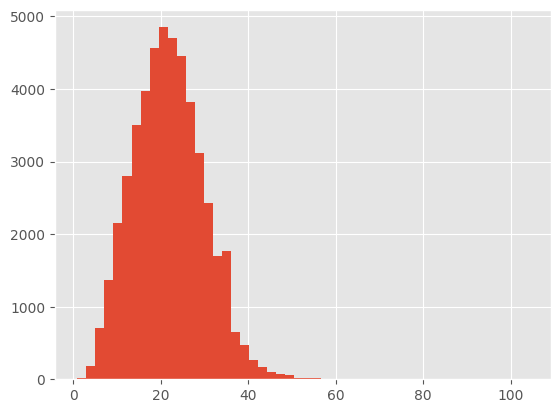

In [29]:
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [30]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len=50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X, value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y, value=tag2idx["O"])
y = [to_categorical(i, num_classes=num_tags) for i in y]

In [31]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [41]:
from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [44]:
model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=max_len, input_length=max_len))
model.add(SpatialDropout1D(0.1))
model.add(Bidirectional(LSTM(units=100, recurrent_dropout=0.1)))
model.add(TimeDistributed(Dense(num_tags, activation='softmax')))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 50, 50)            1758600   
                                                                 
 spatial_dropout1d_3 (Spati  (None, 50, 50)            0         
 alDropout1D)                                                    
                                                                 
 bidirectional_3 (Bidirecti  (None, 50, 200)           120800    
 onal)                                                           
                                                                 
 time_distributed_3 (TimeDi  (None, 50, 17)            3417      
 stributed)                                                      
                                                                 
Total params: 1882817 (7.18 MB)
Trainable params: 1882817 (7.18 MB)
Non-trainable params: 0 (0.00 Byte)
________________

In [45]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Task 7: Train the Model

In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [47]:
epochs = 5

early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1, mode='max',
                               restore_best_weights=False)
callbacks=[early_stopping]

history=model.fit(
    x_train, np.array(y_train),
    validation_split=0.2,
    batch_size=32,
    epochs=epochs,
    verbose=1
)

Epoch 1/5


2023-11-26 18:08:06.465953: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 117402000 exceeds 10% of free system memory.


1080/1080 [==============================] - 127s 109ms/step - loss: 0.1891 - accuracy: 0.9574 - val_loss: 0.0705 - val_accuracy: 0.9797
Epoch 2/5
1080/1080 [==============================] - 122s 113ms/step - loss: 0.0524 - accuracy: 0.9845 - val_loss: 0.0521 - val_accuracy: 0.9845
Epoch 3/5
1080/1080 [==============================] - 130s 121ms/step - loss: 0.0382 - accuracy: 0.9885 - val_loss: 0.0509 - val_accuracy: 0.9848
Epoch 4/5
1080/1080 [==============================] - 131s 121ms/step - loss: 0.0316 - accuracy: 0.9900 - val_loss: 0.0484 - val_accuracy: 0.9855
Epoch 5/5
1080/1080 [==============================] - 130s 120ms/step - loss: 0.0277 - accuracy: 0.9911 - val_loss: 0.0489 - val_accuracy: 0.9856


### Task 8: Evaluate Named Entity Recognition Model

In [ ]:
model.evaluate(x_test, np.array(y_test))

2023-10-25 14:02:48.543738: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 16306400 exceeds 10% of free system memory.


150/150 [==============================] - 9s 59ms/step - loss: 0.0502 - accuracy: 0.9847


[0.05021429806947708, 0.9847122430801392]

In [ ]:
i = np.random.randint(0, x_test.shape[0])
p = model.predict(np.array([x_test[i]]))
p = np.argmax(p, axis=-1)
y_true = np.argmax(np.array(y_test), axis=-1)[i]
print("{:15}{:5}\t{}\n".format("Word", "True", "pred"))

for w, true, pred in zip(x_test[i], y_true, p[0]):
    print(f"{words[w-1]}, {tags[pred]}")

1/1 [==============================] - 0s 137ms/step
Word           True 	pred

The, O
world, O
's, O
largest, O
maker, O
of, O
jetliners, O
,, O
Airbus, B-org
,, O
says, O
it, O
sold, O
more, O
planes, O
than, O
rival, O
Boeing, B-org
last, O
year, O
., O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O
housed, O


In [ ]:
i = np.random.randint(0, x_test.shape[0])
pred=x_test[i]
pred

array([ 7203, 31908, 26767, 34960, 21136, 30839, 29991, 33436, 19929,
       26292, 34960, 28886,  6543, 30288, 20113,   823, 23715, 20113,
       28715, 20113, 31979, 20113, 17847, 20113, 22377, 20113,  6543,
       17842, 31961, 35171, 35171, 35171, 35171, 35171, 35171, 35171,
       35171, 35171, 35171, 35171, 35171, 35171, 35171, 35171, 35171,
       35171, 35171, 35171, 35171, 35171], dtype=int32)

In [ ]:
p = model.predict(np.array([pred]))
p

1/1 [==============================] - 0s 80ms/step


array([[[2.96317972e-04, 1.35090770e-04, 3.69957052e-05, 1.45783080e-04,
         2.75097002e-04, 9.85386312e-01, 1.06402731e-03, 5.56048122e-04,
         5.96521841e-03, 3.20428517e-04, 2.07701139e-03, 4.74142871e-04,
         4.95031782e-05, 9.18230042e-04, 2.19098805e-03, 5.92047909e-05,
         4.97223846e-05],
        [3.25813926e-05, 1.49118987e-05, 1.62720880e-05, 9.99829054e-01,
         2.96205053e-06, 3.41171571e-08, 1.78043138e-07, 3.27974180e-06,
         8.17733780e-06, 7.61623733e-06, 5.44162685e-06, 3.36941230e-06,
         6.56952852e-06, 4.85876990e-06, 3.48244321e-05, 1.99746210e-05,
         9.89682485e-06],
        [5.85241793e-08, 2.68214876e-07, 4.45353550e-07, 9.99994218e-01,
         8.95194585e-09, 4.13757306e-10, 7.84362075e-10, 1.51389301e-07,
         5.17230944e-07, 4.34778997e-07, 7.44191993e-07, 4.07865258e-07,
         2.15325628e-07, 3.81084050e-07, 1.75357354e-06, 2.16268816e-07,
         2.12987359e-07],
        [1.81285742e-07, 1.07368248e-06, 9.550

In [ ]:
new_p = np.argmax(p, axis=-1)
new_p

array([[5, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3]])

In [ ]:
x_test[i]

array([ 7203, 21972, 20166, 13434, 15287, 34960, 22155, 20113,  9666,
       20113, 29636, 24610, 25791, 21568, 18337, 22834,  3916, 16345,
       14694, 27990, 31961, 35171, 35171, 35171, 35171, 35171, 35171,
       35171, 35171, 35171, 35171, 35171, 35171, 35171, 35171, 35171,
       35171, 35171, 35171, 35171, 35171, 35171, 35171, 35171, 35171,
       35171, 35171, 35171, 35171, 35171], dtype=int32)